# Recuperación de información

Para ilustrar los conceptos de recuperación de información usaremos el conjunto de datos de [20 Newsgroups](http://qwone.com/~jason/20Newsgroups/) que se encuentra disponible en [Scikit-learn](https://scikit-learn.org/stable/). 

El conjunto consiste en mensajes en foros, en concreto, hay 20 foros de diversos temas desde hardware hasta religión. Algunos temas están muy relacionados, p.ej. "IBM PC hardware" y "Mac hardware", mientras que otros son más diversos, p.ej. "baseball" o "hockey"). 

## Emulando un buscador con un problema de clasificación en categorías múltiples

Para ejemplificar los conceptos de recuperación de información consideraremos los mensajes del conjunto de entrenamiento del dataset como nuestros documentos a recuperar, y como consultas consideraremos los mensajes del conjunto de prueba. 

Como todos los mensajes tienen como etiqueta el foro al que pertenecen, usaremos esta etiqueta para determinar si la tarea de recuperación ha tenido éxito. En concreto, consideraremos que tomando como consulta un mensaje del foro X, si los mensajes devueltos por nuestra estrategia de recuperación de información son también del foro X consideraremos que la tarea ha tenido éxito, y si fueran de otro foro, querrá decir que no hemos tenido éxito. 

Los pasos que seguiremos serán los siguientes:
1. Vectorización de los mensajes de entrenamiento. Y dado nuestra aproximación, también vectorizaremos cada uno de los mensajes de test que usaremos como consulta.
2. Uso de la similitud del coseno entre el mensaje de consulta y los mensajes de entrenamiento. 
3. Ordenación los resultados de mayor a menor relevancia con la consulta.
4. Cálculo para cada consulta de la precisión de la lista de resultados con nivel de exhaustividad 3 y 10.
  -	La **precisión a un nivel de exhaustividad X** es el número de resultados que son relevantes (en nuestro caso, que son de la clase buscada) de entre los X primeros recuperados.





In [1]:
from sklearn.datasets import fetch_20newsgroups

El conjunto de datos está dividido de forma predeterminada en entrenamiento y prueba en porcentajes de 60 y 40, respectivamente. 

En primer lugar vamos a extraer los datos y vamos a mostrar un ejemplo.

In [2]:
train_data = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)
test_data = fetch_20newsgroups(subset='test')

print("Training texts:", len(train_data.data))
print("Test texts:", len(test_data.data))

Training texts: 11314
Test texts: 7532


In [3]:
print(train_data.data[0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







## Vectorización de datos 

La vectorización se realiza con la utilidad de `CountVectorizer` y debemos  tomar decisiones que afectarán a los resultados de nuestra tarea de clasificación, principalmente:
- Fijar el vocabulario que vamos a usar (parámetro `vocabulary`)
- Determinar la lista de palabras vacías que vamos a usar (parámetro `stop_words`)
- Decidir si vamos a optar por representar los vectores de palabras mediante valores binarios, frecuencias o TF/IDF. 

En nuestro caso usaremos:
- El vocabulario inferido de analizar los mensajes del conjunto de entrenamiento
- La lista de palabras vacías que tiene configurado el `CountVectorizer` de sklearln
- Los vectores de palabras mediante TF/IDF, lo cual requiere usar `TfidfVectorizer` sobre la matriz devuelta por `CountVectorizer`



In [4]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english', binary=False, ngram_range=(1,1))    
   


In [6]:
train_vector_data=vectorizer.fit_transform(train_data.data)

# Extraemos las palabras de nuestro vector de palabras
feature_names = vectorizer.get_feature_names()
print(len(feature_names))

129796


Podemos ver que nuestro vocabulario consiste en más de 129.000 palabras. 

Vamos a ver algunas de ellas al azar para entender mejor nuestro vector de palabras.



In [7]:
print(feature_names[:30])
print(feature_names[6000:6030])
print(feature_names[-30:])

['00', '000', '0000', '00000', '000000', '00000000', '0000000004', '0000000005', '00000000b', '00000001', '00000001b', '0000000667', '00000010', '00000010b', '00000011', '00000011b', '0000001200', '00000074', '00000093', '000000e5', '00000100', '00000100b', '00000101', '00000101b', '00000110', '00000110b', '00000111', '00000111b', '00000315', '000005102000']
['185117', '185118', '185128', '185226', '185235', '1853', '185317', '185326', '185328', '18542', '185448', '18546', '1855', '185510', '1856', '185633', '185638', '1857', '185700', '185706', '185725', '185755', '185806', '185823', '18583', '18590', '18592', '185951', '185c', '185k']
['zznkjz', 'zznkzz', 'zznp', 'zzo', 'zzr11', 'zzr1100', 'zzrk', 'zzt', 'zztop', 'zzy_3w', 'zzz', 'zzzoh', 'zzzz', 'zzzzzz', 'zzzzzzt', 'ªl', '³ation', 'º_________________________________________________º_____________________º', 'ºnd', 'çait', 'çon', 'ère', 'ée', 'égligent', 'élangea', 'érale', 'ête', 'íålittin', 'ñaustin', 'ýé']


Es evidente que hay una gran cantidad de términos numéricos o alfanuméricos de dudoso significado y que pueden generar mucho ruido. 

Con ayuda del parámetro `token_pattern` del `CountVectorizer` y de la [sintaxis de Python para definir expresiones regulares](https://docs.python.org/3/library/re.html) podemos definir que solamente acepte palabras que tengan letras (sin considerar números u otros caracteres especiales).

In [14]:
vectorizer = CountVectorizer(stop_words='english', binary=False, ngram_range=(1,1), token_pattern=r'(?u)\b[A-Za-z]+\b') 

train_vector_data=vectorizer.fit_transform(train_data.data)

feature_names = vectorizer.get_feature_names()
print(len(feature_names))


81461


In [15]:
print(feature_names[:30])
print(feature_names[6000:6030])
print(feature_names[-30:])

['aa', 'aaa', 'aaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaauuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuugggggggggggggggg', 'aaaaagggghhhh', 'aaaarrgghhhh', 'aaah', 'aaahh', 'aaahhhh', 'aaai', 'aab', 'aacc', 'aachen', 'aacvkc', 'aad', 'aaf', 'aah', 'aai', 'aalac', 'aalborg', 'aaldoubo', 'aalternate', 'aam', 'aamazing', 'aamir', 'aammmaaaazzzzzziinnnnggggg', 'aamrl', 'aams', 'aan']
['bdynamic', 'bdz', 'bea', 'beacause', 'beach', 'beachball', 'beachcomber', 'beaches', 'beachfront', 'beacon', 'beacons', 'beacuse', 'bead', 'beaded', 'beadles', 'beads', 'beagle', 'beahvioral', 'beakers', 'beal', 'beale', 'beales', 'beals', 'beam', 'beame', 'beamed', 'beamer', 'beamers', 'beaming', 'beamish']
['zygot', 'zyj', 'zyklon', 'zymmr', 'zyr', 'zyra', 'zysec', 'zysv', 'zyt', 'zyu', 'zyv', 'zyxel', 'zz', 'zzcrm', 'zzd', 'zzneu', 'zznki', 'zznkj', 'zznkjz', 'zznkzz', 'zznp', 'zzo', 'zzrk', 'zzt', 'zztop', 'zzz', 'zzzoh', 'zzzz', 'zzzzzz', 'zzzzzzt']


Ahora vemos un número mucho menor de términos y, aunque hay palabras cuyo significado parece que sigue siendo ruido, el vector ha mejorado notablemente.

In [16]:
from sklearn.feature_extraction.text import TfidfTransformer 

tfidftrans = TfidfTransformer()
train_preprocessed = tfidftrans.fit_transform(train_vector_data)

In [17]:
import numpy as np
import numpy.ma as ma

def write_terms (feature_names, data, vector_data, index):
    '''
    Escribe los términos presentes en un mensaje representado como bolsa de palabras.
    
    - feature_names: terminos usados para vectorizar
    - data: lista de mensajes original (si data==None no se muestra el mensaje original)
    - vector_data: matriz (dispersa) de mensaje vectorizados
    - index: posición del mensaje a mostrar
    '''
    # máscara para seleccionar sólo el mensaje en posición index
    mask=vector_data[index,:]>0
    
    # términos que aparecen en ese mensaje vectorizado
    terminos = ma.array(feature_names, mask = ~(mask[0].toarray()))
    
    # mostrar mensaje original
    if data is not None:
        print('Mensaje', index, ':', data[index])
    
    # mostrar términos que aparecen en el mensaje vectorizado
    print('Mensaje', index, 'vectorizado:', terminos.compressed(),'\n')

## Mostrando un documento vectorizado

El mostrar un documento en su estado original y tras el proceso de vectorización ayuda a entender cómo han funcionado el proceso de vectorización y más adelante a cómo funciona el proceso de recuperación.

In [18]:
write_terms(feature_names, train_data.data, train_preprocessed,100)


Mensaje 100 : From: tchen@magnus.acs.ohio-state.edu (Tsung-Kun Chen)
Subject: ** Software forsale (lots) **
Nntp-Posting-Host: magnusug.magnus.acs.ohio-state.edu
Organization: The Ohio State University
    ****   This is a post for my friend,  You can either call    ****
    ****    him  J.K Lee  (614)791-0748    or Drop me a mail     ****
Distribution: usa
Lines: 39

1.  Software publishing SuperBase 4 windows v.1.3           --->$80

2.  OCR System ReadRight v.3.1 for Windows                  --->$65

3.  OCR System ReadRight  v.2.01 for DOS                    --->$65

4.  Unregistered Zortech 32 bit C++ Compiler v.3.1          --->$ 250
     with Multiscope windows Debugger,
     WhiteWater Resource Toolkit, Library Source Code

5.  Glockenspiel/ImageSoft Commonview 2 Windows
     Applications Framework for Borland C++                 --->$70

6.  Spontaneous Assembly Library With Source Code           --->$50

7.  Microsoft Macro Assembly 6.0                            --->$50

8. 

## Transformación de los ejemplos del conjunto de test

Para hacer nuestras pruebas seleccionaremos los primeros 3 mensajes de cada clase en el conjunto de test

In [19]:
# Tomamos los textos del conjunto de test y los transformamos en una matriz
# de palabras. Al usar "transform" toma como referencia únicamente las palabras
# encontradas en el conjunto de entrenamiento
test_vector_data = vectorizer.transform(test_data.data)

# Si sobre la consulta también realizamos la ponderación TF/IDF estamos amplificando
# el efecto de la misma a la hora de recuperar ejemplos relevantes
test_preprocessed = tfidftrans.transform(test_vector_data)

## Recuperación de ejemplos relevantes y cálculo de precisión a nivel X

Definimos una serie de funciones que nos permiten calcular lo siguiente:

*   Recuperación de los k índices de los documentos más relevantes dada una consulta, un conjunto de documentos y el valor de k
*   Precisión@X, que es la precisión a nivel de exhaustividad X, que nos calcula cuantos de los X primeros documentos de una lista son de la clase deseada 
* Cálculo de la precisión@X media para cada una de las clases del documento



In [20]:
from sklearn.metrics.pairwise import cosine_similarity

def knn(query, X_train, k):
    '''Devuelve los índices de los k documentos de entrenamiento más similares a la consulta usando 
    la similitud del coseno.
    
    Parámetros:
    - query: documento consulta vectorizado
    - X_train: documentos de entrenamiento vectorizados
    - k: número de documentos a recuperar
    
    Devuelve:
    - índices de los k documentos más similares a la consulta.
    '''
    
    # Necesitamos un vector de dimensión (1, X). Si se pasa un vector de dimensión X, transformarlo
    if len(query.shape) == 1:
        query = query.reshape(1, -1)

    simil = cosine_similarity(query, X_train)
    simil_idx = np.argsort(simil.flatten())
    simil_idx = simil_idx[::-1]
    return simil_idx[:k]

In [21]:
def precision_at_k(y_selected, y_real, k):
    '''Devuelve la precisión @k de los documentos seleccionados.
    
    Parametros:
    - y_selected: etiquetas de los documentos seleccionados (se usan los k primeros)
    - y_real: etiqueta de la categoría correcta
    - k: número de documentos que se tienen en cuenta
    
    Devuelve:
    - Precisión@k
    '''
    
    return np.sum(y_selected[:k] == y_real) / k * 100

In [22]:
def mean_precisions_per_class(X_train, y_train, X_test, y_test, k):
    '''Devuelve las precision@k media para cada una de las classes.
    
    Parámetros:
    - X_train: documentos de entrenamiento vectorizados.
    - y_train: etiquetas de los documentos de entrenamiento.
    - X_test: documentos vectorizados que se usan como consultas
    - y_test: etiquetas de los documentos que se usan como consultas
    - k: número de documentos considerados a recuperar por la consulta
    
    Devuelve:
    - Diccionario clase -> precisión en tanto por ciento.
    '''
    
    # diccionario categoría -> lista de precisiones
    y_precisions = {y: [] for y in np.unique(y_test)}
    
    # Calcular precision@k para cada consulta
    for x_query, y_query in zip(X_test, y_test):
        idx = knn(x_query, X_train, k)
        y_selected = np.take(y_train, idx)
        precision = precision_at_k(y_selected, y_query, k)
        y_precisions[y_query].append(precision)
        
    # Calcular medias
    for y in y_precisions:
        y_precisions[y] = np.mean(y_precisions[y])
    
    return y_precisions

## Recuperación de ejemplos relevantes y cálculo de precisión a nivel X

Por simplificar los cálculos vamos a coger solamente los 200 primeros mensajes del conjunto de test y vamos a calcular la precisión@5.

In [23]:
p10 = mean_precisions_per_class(train_preprocessed, train_data.target, test_preprocessed[:200,], test_data.target[:200], 10)
    
p10



{0: 45.55555555555556,
 1: 38.18181818181818,
 2: 26.25,
 3: 43.75,
 4: 29.285714285714285,
 5: 45.0,
 6: 25.714285714285715,
 7: 49.0,
 8: 77.6923076923077,
 9: 70.9090909090909,
 10: 73.07692307692308,
 11: 81.66666666666667,
 12: 40.0,
 13: 52.22222222222222,
 14: 72.72727272727273,
 15: 34.285714285714285,
 16: 66.36363636363636,
 17: 67.0,
 18: 49.09090909090909,
 19: 37.5}

A continuación vamos a mostrar los valores en un gráfico que nos facilite la el análisis visual de los datos.

<AxesSubplot:xlabel='target'>

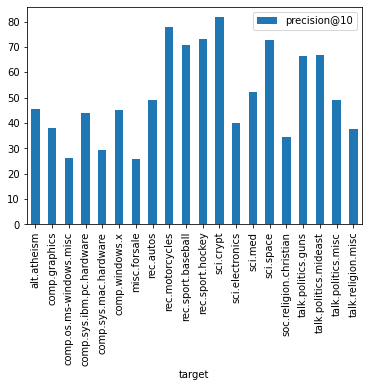

In [24]:
import pandas as pd

df_p10 = pd.DataFrame.from_dict(p10, orient='index', columns=['precision@10'])

df_p10["target"] =  test_data.target_names

d = df_p10.set_index("target")

d.plot.bar()



In [25]:
df_p10

,precision@10,target
0,45.555556,alt.atheism
1,38.181818,comp.graphics
2,26.250000,comp.os.ms-windows.misc
3,43.750000,comp.sys.ibm.pc.hardware
4,29.285714,comp.sys.mac.hardware
5,45.000000,comp.windows.x
6,25.714286,misc.forsale
7,49.000000,rec.autos
8,77.692308,rec.motorcycles
9,70.909091,rec.sport.baseball


Si analizamos los valores de precisión medios para las distintas clases del conjunto de datos podemos ver cosas interesantes, como por ejemplo:

 - Existe mucha diferencia entre los valores de precisión ya que oscilan entre valores cercanos al 25% y valores cercanos al 80%. 
 - Las clases para las que mayor precisión se consiguen son las relacionadoas con criptografía, motociclismo, espacio, hockey y baseball. Esto seguramente es debido a que usan vocabulario específico. 
 - Por el contrario, las clases donde menor precisión se obtiene seguramente sea debido a que los mensajes (que se usan tanto para consulta, como para base de documentos a recuperar) usan un vocabulario más genérico o que se repite entre los distintos temas (el caso de los temas de religión o ateísmo, o de los diversos temas de informática). 
 
Para entender qué está fallando en las clases donde la precisión es baja, sería necesario analizar en mayor detalle las consultas junto con la lista de documentos que recuperan en forma vectorizada. 